In [1]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import math
from matplotlib import pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, input_shape, data, labels,
                 shuffle=True):
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.labels = labels
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
       
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        batch_x = [cv2.cvtColor(cv2.imread(self.data[index]), cv2.COLOR_BGR2RGB) / 255.0 for index in batch_indices]
        batch_y = [cv2.cvtColor(cv2.imread(self.labels[index]), cv2.COLOR_BGR2RGB) / 255.0 for index in batch_indices]
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [4]:
data = []
labels = []
with open('./dataset_cubic.txt', 'r') as f:
    for line in f:
        line = line.strip()
        entry = './DIV2K_processed_cubic/' + line
        data.append(entry + '_X_.png')
        labels.append(entry + '_y_.png')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.05, random_state=42)

In [6]:
train_generator = DataGenerator(128, (48, 48, 3), X_train, y_train, shuffle=True)
test_generator = DataGenerator(128, (48, 48, 3), X_test, y_test, shuffle=True)

In [7]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred[:, :, :, :3], max_val=max_pixel)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred[:, :, :, :3], 2)

def NormalizedMSE(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(y_pred[:, :, :, :3], y_true) / mse(y_true, 0.)

In [8]:
def conv_block(input_data, index: int):
    str_idx = str(index)
    return layers.Conv2D(64, 3, padding='same', activation='relu', name='conv_relu' + str_idx, initializer='he_normal')(input_data)

In [9]:
class VDSR(tf.keras.Model):
    def __init__(self, name='VDSRModel', **kwargs):
        super(VDSR, self).__init__(name=name, **kwargs)
        self.hidden = [layers.Conv2D(64, 3, padding='same', activation='relu', name='conv_relu' + str(idx + 1), kernel_initializer=tf.keras.initializers.HeNormal()) for idx in range(0, 20, 1)]
        self.residual = layers.Conv2D(3, 3, padding='same', name='residual_layer')
    
    def call(self, inputs):
        Z = inputs
        idx = 0
        for layer in self.hidden:
            Z = layer(Z)
            
        residue = self.residual(Z)
        outputs = layers.concatenate([residue + inputs, inputs, residue], axis=3, name='output_layer')
        return outputs
    
    def my_predict(self, x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False):
        prediction = self.predict(x, batch_size, verbose, steps, callbacks, max_queue_size, workers, use_multiprocessing)
        return prediction[:, :, :, :3]

In [10]:
model = VDSR()

In [11]:
def loss(y_true, y_pred):
    inputs = y_pred[:, :, :, 3:6]
    predicted_residue = y_pred[:, :, :, 6:9]
    residue = y_true - inputs
    return 1/2 * tf.math.squared_difference(residue, predicted_residue)

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='SSIM', patience=3, mode='max', restore_best_weights=True)

In [13]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, 
              loss=loss,
              metrics=[PSNR, SSIM, NormalizedMSE])

In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=20, verbose=1)

Epoch 1/20
119/119 [==============================] - 107s 872ms/step - loss: 0.0097 - PSNR: 31.5604 - SSIM: 0.8860 - NormalizedMSE: 0.0657 - val_loss: 7.2598e-04 - val_PSNR: 34.8485 - val_SSIM: 0.9193 - val_NormalizedMSE: 0.0046
Epoch 2/20
119/119 [==============================] - 36s 304ms/step - loss: 7.0422e-04 - PSNR: 35.8737 - SSIM: 0.9261 - NormalizedMSE: 0.0046 - val_loss: 6.8842e-04 - val_PSNR: 36.1736 - val_SSIM: 0.9237 - val_NormalizedMSE: 0.0044
Epoch 3/20
119/119 [==============================] - 36s 304ms/step - loss: 6.9112e-04 - PSNR: 36.6787 - SSIM: 0.9281 - NormalizedMSE: 0.0045 - val_loss: 6.8963e-04 - val_PSNR: 36.5964 - val_SSIM: 0.9246 - val_NormalizedMSE: 0.0044
Epoch 4/20
119/119 [==============================] - 36s 305ms/step - loss: 6.8396e-04 - PSNR: 37.1549 - SSIM: 0.9291 - NormalizedMSE: 0.0044 - val_loss: 6.7857e-04 - val_PSNR: 37.0035 - val_SSIM: 0.9251 - val_NormalizedMSE: 0.0044
Epoch 5/20
119/119 [==============================] - 36s 305ms/step - 

In [22]:
model.summary()

Model: "VDSRModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_relu1 (Conv2D)         multiple                  1792      
                                                                 
 conv_relu2 (Conv2D)         multiple                  36928     
                                                                 
 conv_relu3 (Conv2D)         multiple                  36928     
                                                                 
 conv_relu4 (Conv2D)         multiple                  36928     
                                                                 
 conv_relu5 (Conv2D)         multiple                  36928     
                                                                 
 conv_relu6 (Conv2D)         multiple                  36928     
                                                                 
 conv_relu7 (Conv2D)         multiple                  36

In [23]:
fullimg = cv2.imread("./test_images/test6.jpg", 3)
img_lr = cv2.cvtColor(fullimg, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
# img_lr = 
img_lr = cv2.resize(img_lr, None, fx=1. / 3, fy=1. / 3, interpolation=cv2.INTER_AREA)
img = cv2.resize(img_lr, None, fx = 3, fy = 3, interpolation = cv2.INTER_AREA)
# img = img_lr
lr_input = img.reshape(1, *img.shape)

In [24]:
img_hr = model.predict(lr_input)[0,:, :, :3]
print(np.max(img_hr))
print(np.min(img_hr))

1.0790205
-0.08317846


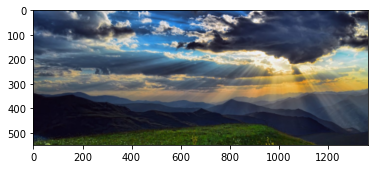

In [25]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


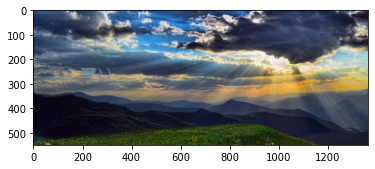

In [26]:
plt.imshow(img_hr)

In [27]:
def SSIMTest(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 2)

print(SSIMTest(tf.image.convert_image_dtype(fullimg[:-1, :-1, :], np.float32), tf.image.convert_image_dtype(img_hr, np.float32)))

tf.Tensor(0.8357604, shape=(), dtype=float32)


In [28]:
cv2.imwrite("./test_images/VDSR_Area2_test6.png", cv2.cvtColor(img_hr, cv2.COLOR_RGB2BGR) * 255)

True

In [29]:
model.save("VDSRv2_Area")

INFO:tensorflow:Assets written to: VDSRv2_Area\assets
